# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

# Data generation

In [5]:
data_dir_list = {
cond_path /"22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations", 
cond_path /"22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations", 
cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations", 
cond_path /"22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations", 
}

running_dir_list = {
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_2xLs.01-.07/simulations", 
cond_path /"22-12-08_aLc1_line800_Ke30_2xLs55nm_kod.1-300/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations"
}

In [6]:
for pth in sorted(list(cond_path.glob("*/simulations"))):
    print(pth.relative_to(cond_path))

22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations
22-08-12_aLchr1_scan8.12_line800_sticky55nm_eps1_5um_Ke5-200/simulations
22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations
22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations
22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations
22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations
22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations
22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations
22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations
22-11-23_equil_scan.12_line800/simulations
22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations
22-12-08_aLchr1_scan7.12_line800_Ke30_kod3.05_2xLs.01-.07/simulations
22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations
22-12-08_aLchr1_scan8.12_line800_Ke30_2xLs55nm_kod.1-300/simulations
22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations
23-01-02_aLc1_

## Connection matrix

In [6]:
def get_connect_smat(prot_arr):
    nlinks = prot_arr.shape[0]
    xlinks = (prot_arr[:,-1] >= 0)
    xlink_coords = prot_arr[xlinks][:,-2:].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    return csr_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])

In [7]:
def get_connect_torch_smat(prot_arr):
    nlinks = prot_arr.shape[0]
    xlinks = (prot_arr[:,-1] >= 0)
    xlink_coords = prot_arr[xlinks][:,-2:].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    tmp = coo_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])
    tmp = torch.from_numpy(tmp.toarray()).to(device=device)
    return tmp.to_sparse_csr()

In [8]:
def connect_autocorr(connect_mat_list):
    n = len(connect_mat_list)
    autocorr_arr = np.zeros(n)
    for i in tqdm(range(n)):
        for j in range(n-i):
            autocorr_arr[i] += connect_mat_list[j].multiply(connect_mat_list[j+i]).sum()
        autocorr_arr[i] /= float(n-i)
    return autocorr_arr

In [51]:
# data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/s1"

# with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     prot_dat = h5_data['raw_data/proteins'][...]
#     connect_mat_list =[]
#     for i in range(time_arr.size):
#         connect_mat_list += [get_connect_smat(prot_dat[:,:,i])]

#     avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)
    
    
    

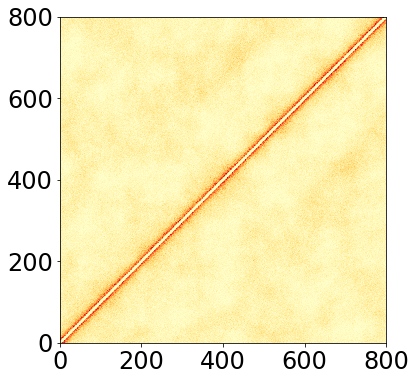

In [50]:

# fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_connect_mat.toarray()
# axarr.set_aspect('equal')
# c = plt.pcolor(mat/time_arr.size)

In [20]:
tsnap_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/"
record_paths = [ 
                tsnap_path / 'kod0.1/s2',
                tsnap_path / 'kod0.3/s1',
                tsnap_path / 'kod1/s1',
                tsnap_path / 'kod10/s1',
                tsnap_path / 'kod30/s1',
                tsnap_path / 'kod300/s1',
                ]

In [14]:
for data_path in tqdm(record_paths):
    print(data_path)
    with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        prot_dat = h5_data['raw_data/proteins'][...]
        connect_mat_list =[]
        for i in range(time_arr.size):
            connect_mat_list += [get_connect_smat(prot_dat[:,:,i])]

    avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)

    with h5py.File(data_path / f'analysis/connect_{data_path.stem}.h5', 'w') as h5_cnct:
        _ = h5_cnct.create_dataset('time', data=time_arr)
        _ = h5_cnct.create_dataset('avg_connect_mat', data=avg_connect_mat.toarray())
        ac_arr = correlate(connect_mat_list[:], connect_mat_list[:])
        _ = h5_cnct.create_dataset('autocorr', data=ac_arr)

  0%|          | 0/6 [00:00<?, ?it/s]

/mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod0.1/s1


In [24]:
for data_path in tqdm(record_paths):
    print(data_path)
    with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        prot_dat = h5_data['raw_data/proteins'][...]
        connect_mat_list =[]
        for i in range(time_arr.size):
            connect_mat_list += [get_connect_torch_smat(prot_dat[:,:,i])]

    avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)

    with h5py.File(data_path / f'analysis/connect_{data_path.stem}.h5', 'w') as h5_cnct:
        _ = h5_cnct.create_dataset('time', data=time_arr)
        _ = h5_cnct.create_dataset('avg_connect_mat', data=avg_connect_mat.to_dense())
        ac_arr = connect_autocorr(connect_mat_list[:])
        _ = h5_cnct.create_dataset('autocorr', data=ac_arr)

  0%|          | 0/1 [00:00<?, ?it/s]

/mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1/s2


AttributeError: 'Tensor' object has no attribute 'toarray'

In [11]:
# for data_path in tqdm(record_paths):
data_path = record_paths[0]
print(data_path)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    attrs = h5_data.attrs
    print(attrs)
    #     time_arr = h5_data['time'][...]
    #     prot_dat = h5_data['raw_data/proteins'][...]
    #     connect_mat_list =[]
    #     for i in range(time_arr.size):
    #         connect_mat_list += [get_connect_smat(prot_dat[:,:,i])]

    # avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)

    with h5py.File(Path.home() / f'tmp_{data_path.stem}.h5', 'w') as h5_cnct:
        for k,v in attrs.items():
            h5_cnct.attrs[k] = v
    #     _ = h5_cnct.create_dataset('time', data=time_arr)
    #     _ = h5_cnct.create_dataset('avg_connect_mat', data=avg_connect_mat.toarray())
    #     ac_arr = connect_autocorr(connect_mat_list[:])
    #     _ = h5_cnct.create_dataset('autocorr', data=ac_arr)

/mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1/s1
<Attributes of HDF5 object at 139648725494016>


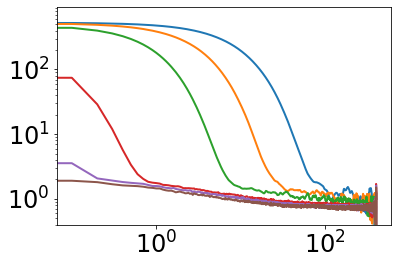

In [21]:
for data_path in record_paths:
    with h5py.File(next(data_path.glob('analysis/Connect*.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4)

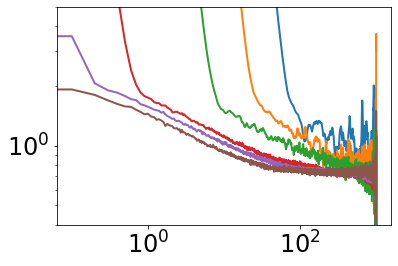

In [22]:
for data_path in record_paths:
    with h5py.File(next(data_path.glob('analysis/connect_analysis.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4, 5)

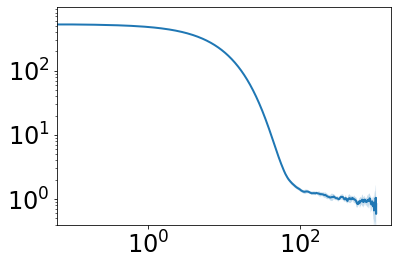

In [30]:
param_dir_path = tsnap_path / 'kod0.1'
ci_bound = .99
ac_arr_list = []
for h5_path in param_dir_path.glob('s*/analysis/connect_analysis.h5'): 
    with h5py.File(h5_path) as h5_data:
        time_arr = h5_data['time'][...]
        ac_arr_list += [h5_data['autocorr'][...]]

n_seeds = len(ac_arr_list)
ac_mean = np.array(ac_arr_list).mean(axis=0)
ci = ((np.array(ac_arr_list).std(axis=0)/np.sqrt(n_seeds)) *
        (np.sqrt(2)*erfinv(ci_bound)))
_ = plt.fill_between(time_arr, 
                    ac_mean - ci, ac_mean + ci, 
                    alpha=.25)
_ = plt.plot(time_arr, ac_mean)
_ = plt.yscale('log')
_ = plt.xscale('log')
# _ = plt.xlim(.1, 10)
_ = plt.ylim(.4)

In [33]:
def save_connect_data(run_path, param_str):
    anal_path = run_path / 'analysis'
    anal_path.mkdir(exist_ok=True)

    # Create an hdf5 file
    h5_path = anal_path / 'connect_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            ac_arrs = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/connect_analysis.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
                if len(sd_h5_data_lst) == 0:
                    print(f'No data files found for parameter directory {pd}')
                    continue
            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][...]
                ac_arrs += [h5_data['autocorr'][...]]

            for h5_data in sd_h5_data_lst:
                h5_data.close()

            min_length = min([_.size for _ in ac_arrs])
            ac_arrs = np.array([_[:min_length] for _ in ac_arrs])

            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  ac_arrs.mean(axis=0)[:, np.newaxis],
                                  ac_arrs.std(axis=0)[:, np.newaxis]))
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = ac_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [45]:
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1", 
#                   param_str="kod")
save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01", 
                  param_str="kod")
save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001", 
                  param_str="kod")
save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001", 
                  param_str="kod")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
def graph_connect_ac_ax(fig, ax, h5_path, 
                        colorbar_label='', 
                        ci_bound = .95,
                        label_str= '{}',
                        show_legend=True,
                        send_cut_ind = 2,
                        fend_cut_ind = -1,
                        ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_ac_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_ac_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_ac_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_ac_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ac_arr - ci, mean_ac_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_xscale('log')
        _ = ax.set_yscale('log')
        # _ = ax.set_ylim(.09, 1)
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

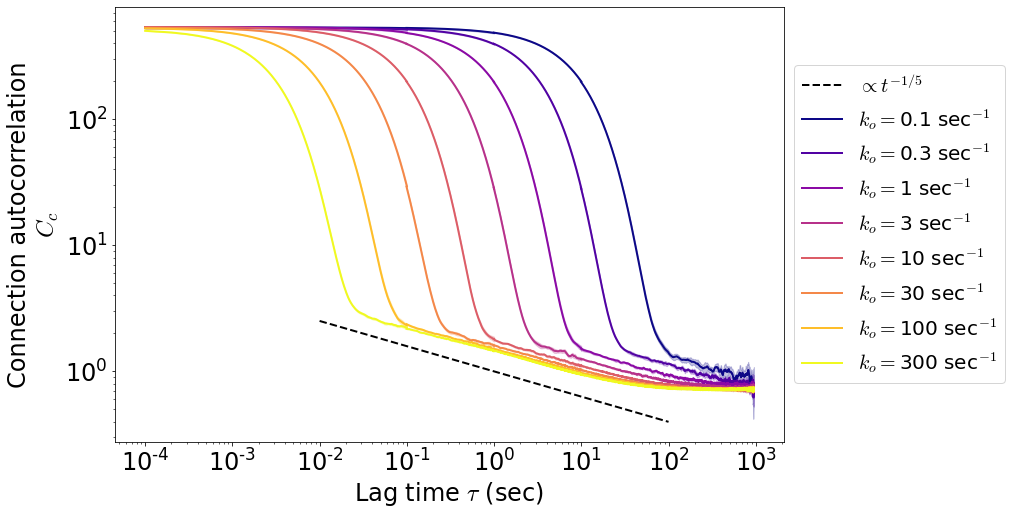

In [24]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
x = np.linspace(.01,100)
y = np.power(x,-.2)
axarr.plot(x,y, linestyle='--', color='k', label=r'$\propto t^{-1/5}$')
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${} sec$^{{-1}}$',
                    show_legend=True, 
                    send_cut_ind=100, fend_cut_ind=-500)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 2, fend_cut_ind = -9000)


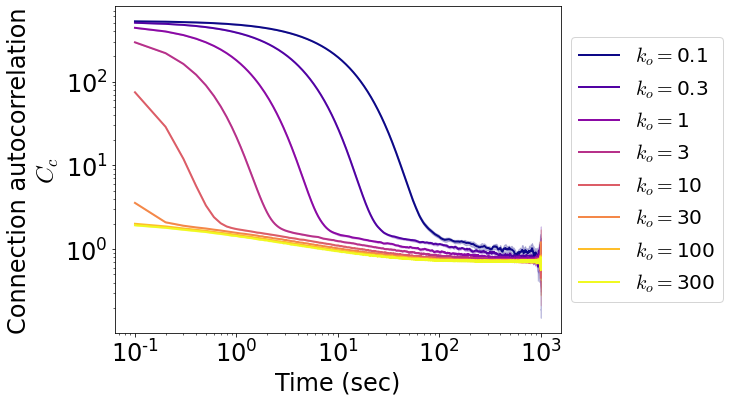

In [70]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}')


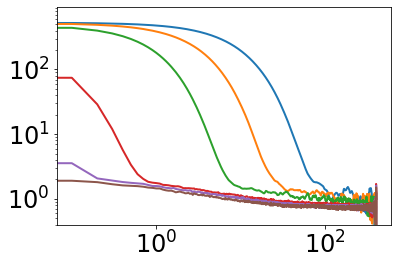

In [ ]:
records_path = cond_path / '23-05-27_aLc1_line800_sticky55nm_kod0-.03_tsnap.001_NB/simulations'
for data_path in record_paths.glob('ko*'):
    with h5py.File(next(data_path.glob('analysis/Connect*.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4)

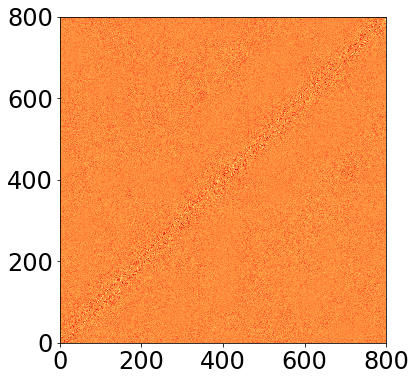

In [40]:

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_sparse_mat.toarray()
avg_mat = mat/time_arr.size
axarr.set_aspect('equal')
c = axarr.pcolor(avg_mat - avg_mat.T)

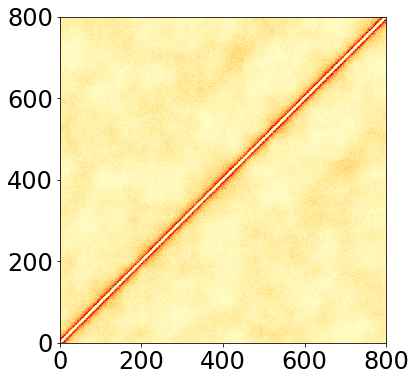

In [41]:

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_sparse_mat.toarray()
avg_mat = mat/time_arr.size
axarr.set_aspect('equal')
c = axarr.pcolor(.5 *(avg_mat + avg_mat.T))

In [ ]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/s1"

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    nlinks = prot_dat.shape[0]

    xlinks = (prot_dat[:,-1,-1] >= 0)
    xlink_coords = prot_dat[xlinks][:,-2:, -1].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    sparse_mat1 = coo_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])

# Crosslink ratio

In [ ]:
def save_slice_crosslink_ratio_data(run_path,
                    param_str_list, 
                    ss_rog_avg_start_ind=-600,
                    ss_ind = 1,
                    end_ind = -1,
                    start_bead = 0,
                    end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'crosslink_slice_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['params'] = param_str_list

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str_list[0]}(\d*\.?\d+)_{param_str_list[1]}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            rog_arrs = []
            clps_times = []
            avg_clps_rog_arr = []
            std_clps_rog_arr = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                rog = aa.calc_rad_of_gyration(com_arr)
                clps_ind = ahlp.find_steady_state_ind(
                    rog, [ss_rog_avg_start_ind, None])
                rog_arrs += [rog.tolist()]
                clps_times += [time_arr[clps_ind]]
                avg_clps_rog_arr += [rog[clps_ind:].mean()]
                std_clps_rog_arr += [rog[clps_ind:].std()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in rog_arrs])
            rog_arrs = np.array([_[:min_length] for _ in rog_arrs])

            # Create dataset
            match = mp.match(pd.name)
            pvals = [match[1], match[2]]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  rog_arrs.mean(axis=0)[:, np.newaxis],
                                  rog_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(pd.name, data=data_arr)
            d_set.attrs[param_str_list[0]] = pvals[0]
            d_set.attrs[param_str_list[1]] = pvals[1] 
            d_set.attrs['seeds'] = rog_arrs.shape[0]
            d_set.attrs['collapse_times'] = clps_times
            d_set.attrs['avg_collapse_rog'] = avg_clps_rog_arr
            d_set.attrs['std_collapse_rog'] = std_clps_rog_arr

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            

            for h5d in sd_h5_data_lst:
                h5d.close()

In [ ]:
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke100/s1"
fig, ax = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 100')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke50/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 50')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke20/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 20')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke10/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 10')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke5/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 5')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke1/s2"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 2')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke1/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 1')

_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Ratio Bound-to-unbound crosslinks')

_ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# Testing

In [ ]:
prot_dat_path = Path("/dev/shm/2xLs55nm_omp2/result/result0-399/ProteinAscii_1.dat")
syl_dat_path = Path("/dev/shm/2xLs55nm_omp2/result/result0-399/SylinderAscii_1.dat")
prots = arf.read_dat_xlp(prot_dat_path)
syls = [fil.get_dat()
            for fil in arf.read_dat_sylinder(syl_dat_path) 
            if (fil.fil_type != 'L')]
print(prots[0].get_dat())
# print(syls[50].gid)
print(len(syls))
n_beads = len(syls)


In [ ]:

connect_mat = np.zeros((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    connect_mat[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    connect_mat[end1, end0] = connect_mat[end0, end1]
    


In [ ]:
plt.pcolor(connect_mat)
np.sum(connect_mat)


In [ ]:

from scipy.sparse import csc_matrix
csc_connect = csc_matrix((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    csc_connect[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    csc_connect[end1, end0] = csc_connect[end0, end1]
plt.pcolor(csc_connect.toarray())
import scipy
scipy.__version__

In [ ]:
].gid)
print(len(syls))
n_beads = len(syls)

connect_mat = np.zeros((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    connect_mat[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    connect_mat[end1, end0] = connect_mat[end0, end1]
plt.pcolor(connect_mat)
np.sum(connect_mat)
from scipy.sparse import csc_matrix
csc_connect = csc_matrix((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    csc_connect[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    csc_connect[end1, end0] = csc_connect[end0, end1]
plt.pcolor(csc_connect.toarray())
import scipy
scipy.__version__